In [2]:
%%time

import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from helper_funcs import *
import shutil
from scipy.stats import ttest_ind,ttest_1samp,ttest_rel

import umap

CPU times: user 10.8 s, sys: 5.13 s, total: 15.9 s
Wall time: 29.2 s


In [3]:
%%time
import ants

CPU times: user 1.75 s, sys: 1.08 s, total: 2.83 s
Wall time: 19.9 s


In [4]:
analysis_name = 'CVAE_2022-03-25 18:28:49.469238'
save_dir = os.path.join('../Assets/tf_weights',analysis_name)

In [5]:
def dummy_ordinal(invec):
    unique_values = np.unique(invec)
    new_values = np.arange(1,len(unique_values)+1)
    new_arr = [new_values[val==unique_values][0] for val in invec]
    return new_arr

In [6]:
def flatten_cmat(cmats):
    ns = cmats.shape[0]
    ni = cmats.shape[-1]
    tridx = np.triu_indices(n=ni,k=1)
    mat_flat = np.array([cmats[i,:,:][tridx] for i in range(ns)])
    return mat_flat

In [7]:
df = pd.read_csv('../Data/comb_df.csv')
df['dataset_id'] = dummy_ordinal(df['dataset'])
df['site_id'] = dummy_ordinal(df['site'])


u_sites = np.unique(df['site_id'].values)
sites = df['site_id'].values.astype(float)
site_ratios = np.array([(df['diag'].values[df['site_id'].values==s]==1).mean() for s in u_sites])
bad_sites = u_sites[abs(site_ratios-.5)>.1]
sites[df['site_id'].isin(bad_sites).values] = np.nan
df['sites_bal'] = sites
print((~np.isnan(df['sites_bal'].values)).sum())


patients = df['diag'].values==1
df_asd = df.iloc[patients]
df_td = df.iloc[~patients]

print(df_asd.shape)
print(df_td.shape)

df

1025
(661, 16)
(841, 16)


,Unnamed: 0,participant_id,diag,age,sex,fiq,site,DSMIV,ados_total,ados_social,ados_comm,ados_rrb,dataset,dataset_id,site_id,sites_bal
0,0,50002,1,16.77,1,103.0,13,1.0,12.0,8.0,4.0,3.0,ABIDE I,1,4,4.0
1,2,50004,1,19.09,1,113.0,13,1.0,18.0,12.0,6.0,2.0,ABIDE I,1,4,4.0
2,3,50005,1,13.73,2,119.0,13,1.0,12.0,8.0,4.0,1.0,ABIDE I,1,4,4.0
3,4,50006,1,13.37,1,109.0,13,1.0,12.0,8.0,4.0,4.0,ABIDE I,1,4,4.0
4,9,50011,1,16.93,1,111.0,13,1.0,13.0,9.0,4.0,NaN,ABIDE I,1,4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,746,30163,2,8.00,2,136.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29,NaN
1498,747,30164,2,10.00,2,115.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29,NaN
1499,748,30165,2,12.00,2,120.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29,NaN
1500,749,30166,2,10.00,2,112.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29,NaN


In [100]:
def get_epi_fn(s,pref='sfrc'):
    # Figures out the epi filename from df index
    subID = df['participant_id'].values[s]
    if df['dataset'].values[s]=='ABIDE I':
        epi_fn = f'~/data/ABIDE/Derivatives/preprocessed/sub-00{subID}/{pref}-sub-00{subID}_bold.nii.gz' # ABIDE I
        epi_fn = os.path.expanduser(epi_fn)

    elif df['dataset'].values[s]=='ABIDE II': # ABIDE II
        subroot = os.path.expanduser(f'~/data/ABIDE2/Derivatives/preprocessed/sub-{subID}/')
        sess_folders = os.listdir(subroot)
        sess_folders.sort()
        epi_fn = os.path.join(subroot,sess_folders[0],f'{pref}-sub-{subID}_bold.nii.gz')

    assert os.path.exists(epi_fn),'file doesnt exist'
    
    return epi_fn

In [101]:
df['epi_fn'] = [get_epi_fn(s) for s in range(len(df))]

In [102]:
def get_roi_timeseries(fn):
    # returns 51xnT matrix
    #fn = df['epi_fn'].values[bad_subs_idx[0]]
    im = ants.image_read(fn)
    #im = im.resample_image(resample_params=(64,64,64,im.shape[-1]), use_voxels=True, interp_type=4)
    im = im.resample_image(resample_params=(64,64,64,im.shape[-1]), use_voxels=True)

    #atlas = ants.image_read('../Data/YeoAtlas/epi_rois.nii.gz').resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1)
    atlas = ants.image_read('../Data/YeoAtlas/epi_rois.nii.gz')
    atlas = ants.resample_image_to_target(atlas,im.slice_image(axis=3,idx=0),interp_type='nearestNeighbor')
    assert len(np.unique(atlas.numpy()))==52,'bad interpolation'

    epi_flat = im.numpy().reshape(im.shape[-1],-1)
    atlas_flat = atlas.flatten()
    roi_timeseries = np.array([epi_flat[:,atlas_flat==r].mean(axis=1) for r in np.arange(1,52)])
    return roi_timeseries

In [104]:
# Extract ROI_timeseries and cmat data
#ofdir = os.path.expanduser('~/BC-fMRI-AE/Assets/fc-mats-Jul5th2022/')
#ofdir = os.path.expanduser('~/BC-fMRI-AE/Assets/fc-mats-Jul5th2022-sfrc')
ofdir = os.path.expanduser('~/BC-fMRI-AE/Assets/fc-mats-Jul11th2022-sfrc')

if not os.path.exists(ofdir):
    os.mkdir(ofdir)
    
for s in tqdm(range(len(df))):
    sNum = f'{s:04d}'
    epi_fn = df['epi_fn'].values[s]
    
    if not os.path.exists(os.path.join(ofdir,sNum+'_roi_timeseries.npy')):
        roi_timeseries = get_roi_timeseries(epi_fn)
        np.save(file=os.path.join(ofdir,sNum+'_roi_timeseries.npy'), arr=roi_timeseries)
        
    if not os.path.exists(os.path.join(ofdir,sNum+'_cmat.npy')):
        cmat = np.corrcoef(roi_timeseries)
        np.save(file=os.path.join(ofdir,sNum+'_cmat.npy'), arr=cmat)

100%|██████████| 1502/1502 [2:17:08<00:00,  5.48s/it] 


In [30]:
files = os.listdir(ofdir)
files.sort()

In [31]:
cmat_files = [file for file in files if file.endswith('_cmat.npy')]
timeseries_files = [file for file in files if file.endswith('_timeseries.npy')]

In [32]:
new_cmats = np.array([np.load(os.path.join(ofdir,cmat_files[i])) for i in tqdm(range(len(cmat_files)))])
new_cmats = ((new_cmats+1)/2) # norm between 0 and 1

100%|██████████| 1502/1502 [00:03<00:00, 405.20it/s]


In [33]:
new_timeseries = [np.load(os.path.join(ofdir,timeseries_files[i])) for i in tqdm(range(len(timeseries_files)))]

100%|██████████| 1502/1502 [00:04<00:00, 361.94it/s]


In [34]:
## Load Data
cmats = np.load('../Data/cmats_r51_S1502.npz')['data']
cmats_rel = np.load('../Data/rel-cmats_r51_S1502.npz')['data']
cmats_asd_flat = flatten_cmat(cmats[patients,:,:])

print(cmats.shape)
print(cmats_rel.shape)
print(cmats_asd_flat.shape)

(1502, 51, 51)
(1502, 2, 51, 51)
(661, 1275)


In [35]:
def depad(mat,idx=(6,57)):
    'depads the cmats'
    if mat.ndim==3:
        mat_trimmed = mat[:,idx[0]:idx[1],idx[0]:idx[1]]
    elif mat.ndim==4:
        mat_trimmed = mat[:,:,idx[0]:idx[1],idx[0]:idx[1]]
    else:
        print(mat.shape)
        raise Exception("Not implemented")
        
    return mat_trimmed

In [36]:
%%time

data = np.load(os.path.join(save_dir,'results.npz'))
data = dict(data)
data_keys = list(data.keys())

# Z_mu = data['Z_mu']
# Z_sigma = data['Z_sigma']
# Z = data['Z']
# S_mu = data['S_mu']
# S_sigma = data['S_sigma']
# S = data['S']
# Z_sample100 = data['Z_sample100']
# S_sample100 = data['S_sample100']

data['recon_td_mu'] = depad(data['recon_td_mu'])
data['recon_asd_mu'] = depad(data['recon_asd_mu'])
data['recon_twin_mu'] = depad(data['recon_twin_mu'])
data['recon_td_samples'] = depad(data['recon_td_samples'])
data['recon_asd_samples'] = depad(data['recon_asd_samples'])
data['recon_twin_samples'] = depad(data['recon_twin_samples'])

data['Z_asd_sample10'] = data['Z_sample100'][0:10,patients,:]
data['S_asd_sample10'] = data['S_sample100'][0:10,patients,:]

for key in data_keys:
    print(f'{key.center(20)} | {data[key].shape}')

        Z_mu         | (1502, 16)
      Z_sigma        | (1502, 16)
         Z           | (1502, 16)
        S_mu         | (1502, 16)
      S_sigma        | (1502, 16)
         S           | (1502, 16)
    Z_sample100      | (100, 1502, 16)
    S_sample100      | (100, 1502, 16)
    recon_td_mu      | (841, 51, 51)
    recon_asd_mu     | (661, 51, 51)
   recon_twin_mu     | (661, 51, 51)
  recon_td_samples   | (100, 841, 51, 51)
 recon_asd_samples   | (100, 661, 51, 51)
 recon_twin_samples  | (100, 661, 51, 51)
CPU times: user 20.9 s, sys: 811 ms, total: 21.7 s
Wall time: 21.8 s


98

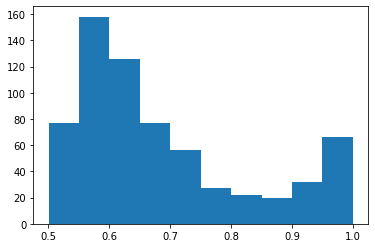

In [43]:
avg_conn = np.array([flatten_cmat(cmats[patients,:,:])[s,:].mean() for s in range(patients.sum())])
plt.hist(avg_conn)
(avg_conn>.9).sum()

0

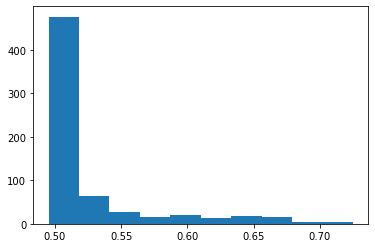

In [38]:
avg_conn = np.array([flatten_cmat(new_cmats[patients,:,:])[s,:].mean() for s in range(patients.sum())])
plt.hist(avg_conn)
(avg_conn>.9).sum()

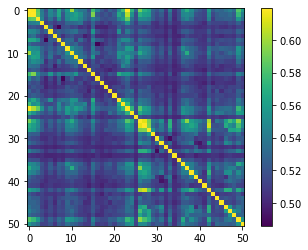

In [39]:
mcmat = new_cmats.mean(axis=0)
plt.imshow(mcmat)
plt.clim(get_triu(mcmat).min(),get_triu(mcmat).max())
plt.colorbar()

In [40]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

In [45]:
bad_subs_bool = avg_conn>.9
bad_subs_idx = np.nonzero(bad_subs_bool)[0]
bad_subs = df.iloc[patients]['participant_id'].values[avg_conn>.9]
bad_subs

array([50118, 50125, 50127, 50131, 50132, 50133, 50601, 50602, 50604,
       50605, 50606, 50608, 50609, 50610, 50612, 50618, 50619, 50955,
       50956, 50957, 50959, 50964, 50965, 50967, 50969, 50970, 50971,
       50972, 50973, 50975, 50976, 50980, 50982, 50984, 50989, 50990,
       50991, 50992, 50996, 50997, 50998, 50999, 51001, 51002, 51003,
       51009, 51010, 51011, 51012, 51017, 51018, 51021, 51024, 51026,
       51029, 51032, 29151, 29152, 29153, 29154, 29155, 29156, 29159,
       29163, 29164, 29166, 29169, 29170, 29173, 29174, 29178, 29181,
       29182, 29185, 29186, 29189, 29191, 29194, 29195, 29197, 29199,
       29200, 29204, 29208, 29210, 29216, 29220, 29223, 29864, 29865,
       29866, 29867, 29870, 29872, 29874, 29877, 29879, 29881])

In [46]:
bad_subs_idx

array([ 16,  17,  18,  20,  21,  22, 149, 150, 152, 153, 154, 156, 157,
       158, 159, 160, 161, 210, 211, 212, 214, 218, 219, 221, 223, 224,
       225, 226, 227, 229, 230, 234, 236, 238, 243, 244, 245, 246, 250,
       251, 252, 253, 255, 256, 257, 261, 262, 263, 264, 268, 269, 272,
       274, 276, 279, 280, 471, 472, 473, 474, 475, 476, 478, 481, 482,
       484, 487, 488, 490, 491, 494, 496, 497, 499, 500, 503, 505, 508,
       509, 511, 513, 514, 518, 521, 523, 527, 528, 530, 630, 631, 632,
       633, 636, 637, 638, 640, 641, 642])

In [17]:
sub = bad_subs_idx[0]
#sub = 0
roi_timeseries = get_roi_timeseries(df['epi_fn'].values[patients][sub])
# Normalize each ROI
roi_timeseries = (roi_timeseries-roi_timeseries.min(axis=1)[:,np.newaxis]) / (roi_timeseries.max(axis=1)[:,np.newaxis]-roi_timeseries.min(axis=1)[:,np.newaxis])

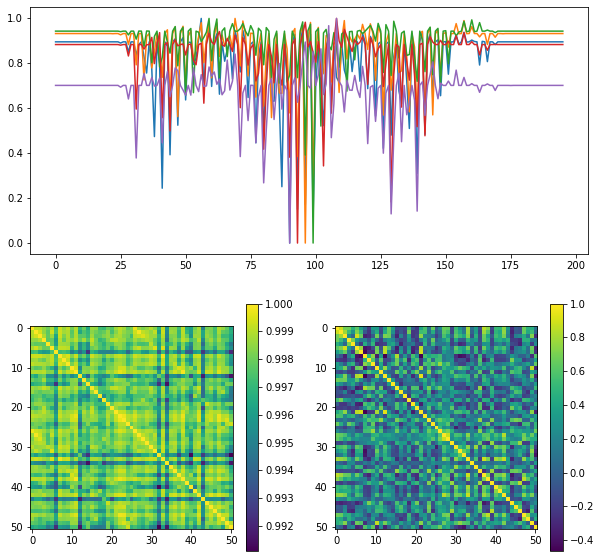

In [18]:
plt.figure(figsize=np.array((5,5))*2)
plt.subplot(2,1,1)
plt.plot(roi_timeseries[0:5,:].transpose())
plt.subplot(2,2,3)
plt.imshow(cmats[patients,:,:][sub,:,:])
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(np.corrcoef(roi_timeseries))
plt.colorbar()

In [19]:
sub = 0
roi_timeseries = get_roi_timeseries(df['epi_fn'].values[sub])
# Normalize each ROI
roi_timeseries = (roi_timeseries-roi_timeseries.min(axis=1)[:,np.newaxis]) / (roi_timeseries.max(axis=1)[:,np.newaxis]-roi_timeseries.min(axis=1)[:,np.newaxis])

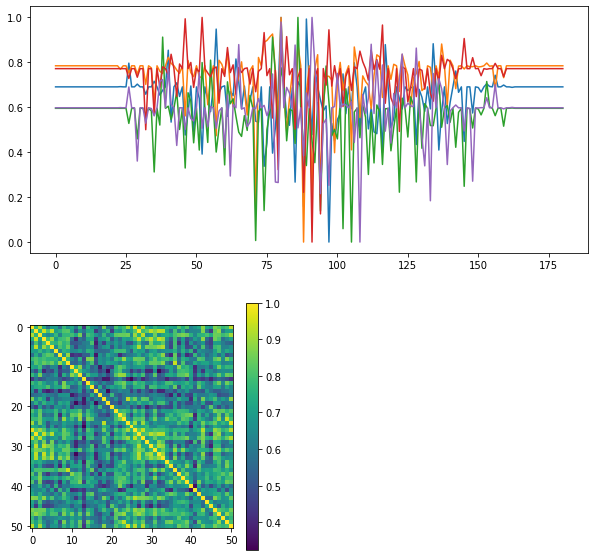

In [20]:
plt.figure(figsize=np.array((5,5))*2)
plt.subplot(2,1,1)
plt.plot(roi_timeseries[0:5,:].transpose())
plt.subplot(2,2,3)
plt.imshow(cmats[patients,:,:][sub,:,:])
plt.colorbar()